In [ ]:
!pip install git+https://gitlab.com/neu-autonomy/gym-neu-racing.git

  Cloning https://gitlab.com/neu-autonomy/gym-neu-racing.git to /tmp/pip-req-build-uoxtcb6c
  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/gym-neu-racing.git /tmp/pip-req-build-uoxtcb6c
  Resolved https://gitlab.com/neu-autonomy/gym-neu-racing.git to commit 229bca41c3fe83eae3025e2cd7b8a9dfb7ee1d3f
  Preparing metadata (setup.py) ... done


In [ ]:
import gymnasium
import numpy as np
import gym_neu_racing
from gymnasium import spaces
from gym_neu_racing.envs.wrappers import StateFeedbackWrapper, MappingWrapper
import matplotlib.pyplot as plt
from typing import Callable
import matplotlib.cm as cmx
import matplotlib.colors as colors
from gym_neu_racing import motion_models
from gym_neu_racing.motion_models.motion_model import MotionModel
from gym_neu_racing import sensor_models
from gym_neu_racing.sensor_models.sensor_model import SensorModel
from gym_neu_racing.envs.map import Map
from skimage.draw import line
from gym_neu_racing.sensor_models import Lidar2D
import scipy
from scipy.linalg import expm

In [ ]:
%%writefile fssm.py

"""Fast Spectral Scan Matching (F-SSM) implementation.

This module implements the F-SSM algorithm described in the paper:
'Coarse-to-Fine Localization for a Mobile Robot Based on Place Learning with a 2-D Range Scan'
by Soonyong Park and Kyung Shik Roh.

The F-SSM algorithm is an adaptation of the Fast Spectral Graph Matching (FASM) method
for scan matching. It approximates the affinity matrix using the linear combination of
Kronecker products of basis and index matrices for efficient computation.
"""

import numpy as np
from scipy.optimize import linear_sum_assignment

class FSSM:
    """Fast Spectral Scan Matching implementation."""

    def __init__(self, bin_width=0.1, sigma_d=0.8):
        """Initialize F-SSM with parameters.

        Args:
            bin_width (float): Width of distance bins in mm for approximate matching (w in paper)
            sigma_d (float): Parameter to control matching sensitivity in mm (σd in paper)
        """
        self.bin_width = bin_width
        self.sigma_d = sigma_d

    def approximate_distance(self, distance):
        """Approximate a distance value using bin width.

        This implements equation (2) from the paper.

        Args:
            distance (float): Original distance value

        Returns:
            float: Approximated distance value
        """
        bin_idx = int(distance / self.bin_width)
        return self.bin_width * (bin_idx + 0.5)

    def compute_affinity_score(self, d_ij, d_i_j_prime):
        """Compute affinity score between two pairs of points.

        This implements equation (4) from the paper.

        Args:
            d_ij (float): Distance between points i and j in first scan
            d_i_j_prime (float): Distance between points i' and j' in second scan

        Returns:
            float: Affinity score (0 if pairs are not compatible)
        """
        diff = abs(d_ij - d_i_j_prime)
        if diff < 3 * self.sigma_d:
            return 4.5 - (diff ** 2) / (2 * (self.sigma_d ** 2))
        return 0

    def create_basis_matrices(self, scan1, scan2):
        """Create basis matrices for the approximate affinity matrix.

        Args:
            scan1 (np.ndarray): First scan points, shape (n1, 2)
            scan2 (np.ndarray): Second scan points, shape (n2, 2)

        Returns:
            tuple: (bases, index_matrices)
                - bases: List of basis matrices
                - index_matrices: List of index matrices corresponding to bases
        """
        n1 = scan1.shape[0]
        n2 = scan2.shape[0]

        # Calculate pairwise distances within each scan
        # For scan1
        d1 = np.zeros((n1, n1))
        for i in range(n1):
            for j in range(n1):
                if i != j:
                    d1[i, j] = np.linalg.norm(scan1[i] - scan1[j])

        # For scan2
        d2 = np.zeros((n2, n2))
        for i in range(n2):
            for j in range(n2):
                if i != j:
                    d2[i, j] = np.linalg.norm(scan2[i] - scan2[j])

        # Approximate distances
        d1_approx = np.zeros_like(d1)
        for i in range(n1):
            for j in range(n1):
                if i != j:
                    d1_approx[i, j] = self.approximate_distance(d1[i, j])

        # Find unique approximated distances in scan1
        unique_distances = np.unique(d1_approx[d1_approx > 0])

        # Create bases and index matrices
        bases = []
        index_matrices = []

        for dist in unique_distances:
            # Create basis matrix B_i for this distance
            B_i = np.zeros((n2, n2))
            for i in range(n2):
                for j in range(n2):
                    if i != j:
                        B_i[i, j] = self.compute_affinity_score(dist, d2[i, j])

            # Create index matrix H_i for this distance
            H_i = np.zeros((n1, n1))
            for i in range(n1):
                for j in range(n1):
                    if i != j and d1_approx[i, j] == dist:
                        H_i[i, j] = 1

            # Only add non-zero bases and corresponding index matrices
            if np.sum(B_i) > 0:
                bases.append(B_i)
                index_matrices.append(H_i)

        return bases, index_matrices

    def bases_power_method(self, bases, index_matrices, max_iter=50, tol=1e-6):
        """Implement the bases power method with bistochastic normalization.

        This implements Algorithm 1 from the paper.

        Args:
            bases (list): List of basis matrices
            index_matrices (list): List of index matrices
            max_iter (int): Maximum number of iterations
            tol (float): Convergence tolerance

        Returns:
            np.ndarray: Assignment matrix V
        """
        n1 = index_matrices[0].shape[0]
        n2 = bases[0].shape[0]

        # Initialize v with random values and normalize
        v = np.random.rand(n1 * n2)
        v = v / np.linalg.norm(v)

        # Power method iterations
        for _ in range(max_iter):
            # Matrix-vector multiplication
            z = np.zeros_like(v)
            for basis, index_matrix in zip(bases, index_matrices):
                # Implement equation (6) from the paper
                for j in range(n1):
                    for x in range(n1):
                        if index_matrix[x, j] > 0:
                            v_j = v[j*n2:(j+1)*n2]
                            z_x = z[x*n2:(x+1)*n2]
                            z[x*n2:(x+1)*n2] = z_x + index_matrix[x, j] * basis @ v_j

            # Normalize the vector
            z_norm = np.linalg.norm(z)
            if z_norm < tol:
                break
            z = z / z_norm

            # Bistochastic normalization (Sinkhorn algorithm)
            V = z.reshape(n1, n2)

            # Apply bistochastic normalization until convergence
            prev_V = None
            for _ in range(50):  # Limit iterations for normalization
                # Normalize rows
                row_sums = V.sum(axis=1, keepdims=True)
                row_sums[row_sums == 0] = 1  # Avoid division by zero
                V = V / row_sums

                # Normalize columns
                col_sums = V.sum(axis=0, keepdims=True)
                col_sums[col_sums == 0] = 1  # Avoid division by zero
                V = V / col_sums

                # Check convergence
                if prev_V is not None and np.allclose(V, prev_V, atol=tol):
                    break
                prev_V = V.copy()

            # Reshape V back to vector v
            v = V.flatten()

            # Check convergence
            if np.allclose(v, z, atol=tol):
                break

        # Return assignment matrix V
        return v.reshape(n1, n2)


    def match(self, scan1, scan2):
        """Match two range scans using F-SSM.

        Args:
            scan1 (np.ndarray): First scan points, shape (n1, 2)
            scan2 (np.ndarray): Second scan points, shape (n2, 2)

        Returns:
            tuple: (R, t, correspondences)
                - R (np.ndarray): Rotation matrix (2x2)
                - t (np.ndarray): Translation vector (2,)
                - correspondences (list): List of tuples (i, j) representing correspondences
                  between points in scan1 and scan2
        """
        # Create basis and index matrices
        bases, index_matrices = self.create_basis_matrices(scan1, scan2)

        # Compute assignment matrix using bases power method
        assignment_matrix = self.bases_power_method(bases, index_matrices)

        # Apply Hungarian algorithm to find discrete assignments
        row_indices, col_indices = linear_sum_assignment(-assignment_matrix)

        # Create correspondence pairs
        correspondences = [(i, j) for i, j in zip(row_indices, col_indices)]

        # Estimate transformation using RANSAC
        R, t = self.ransac_estimation(scan1, scan2, correspondences)

        return R, t, correspondences

    def ransac_estimation(self, scan1, scan2, correspondences, max_iter=50, threshold=0.1):
        """RANSAC-based estimation of transformation between scans.

        Args:
            scan1 (np.ndarray): First scan points, shape (n1, 2)
            scan2 (np.ndarray): Second scan points, shape (n2, 2)
            correspondences (list): List of correspondence pairs
            max_iter (int): Maximum number of RANSAC iterations
            threshold (float): Inlier threshold distance

        Returns:
            tuple: (R, t)
                - R (np.ndarray): Rotation matrix (2x2)
                - t (np.ndarray): Translation vector (2,)
        """
        best_R = np.eye(2)
        best_t = np.zeros(2)
        max_inliers = 0

        for _ in range(max_iter):
            # Randomly select two correspondence pairs
            if len(correspondences) < 2:
                continue

            idx1, idx2 = np.random.choice(len(correspondences), 2, replace=False)
            i1, j1 = correspondences[idx1]
            i2, j2 = correspondences[idx2]

            # Get the corresponding points
            p1 = scan1[i1]
            q1 = scan2[j1]
            p2 = scan1[i2]
            q2 = scan2[j2]

            # Compute tentative transformation
            # This implements equation (7) from the paper
            # First, calculate the rotation angle
            dp = p2 - p1
            dq = q2 - q1

            if np.linalg.norm(dp) < 1e-6 or np.linalg.norm(dq) < 1e-6:
                continue

            theta = np.arctan2(dp[1], dp[0]) - np.arctan2(dq[1], dq[0])

            # Compute rotation matrix
            c, s = np.cos(theta), np.sin(theta)
            R = np.array([[c, -s], [s, c]])

            # Compute translation
            t = p1 - R @ q1

            # Count inliers
            inliers = 0
            for i, j in correspondences:
                error = np.linalg.norm(scan1[i] - (R @ scan2[j] + t))
                if error < threshold:
                    inliers += 1

            # Update best transformation if we have more inliers
            if inliers > max_inliers:
                max_inliers = inliers
                best_R = R
                best_t = t

        # Refine transformation using all inliers
        inlier_src = []
        inlier_dst = []

        for i, j in correspondences:
            error = np.linalg.norm(scan1[i] - (best_R @ scan2[j] + best_t))
            if error < threshold:
                inlier_src.append(scan1[i])
                inlier_dst.append(scan2[j])

        if len(inlier_src) >= 2:
            # Recalculate transformation with all inliers using SVD
            inlier_src = np.array(inlier_src)
            inlier_dst = np.array(inlier_dst)

            # Center the point sets
            src_mean = np.mean(inlier_src, axis=0)
            dst_mean = np.mean(inlier_dst, axis=0)

            src_centered = inlier_src - src_mean
            dst_centered = inlier_dst - dst_mean

            # Compute rotation using SVD
            H = src_centered.T @ dst_centered
            U, _, Vt = np.linalg.svd(H)
            R = U @ Vt

            # Ensure proper rotation matrix (determinant 1)
            if np.linalg.det(R) < 0:
                Vt[-1, :] *= -1
                R = U @ Vt

            # Compute translation
            t = src_mean - R @ dst_mean

            best_R = R
            best_t = t

        return best_R, best_t

    def transform_scan(self, scan, R, t):
        """Transform a scan using rotation and translation.

        Args:
            scan (np.ndarray): Scan points, shape (n, 2)
            R (np.ndarray): Rotation matrix (2x2)
            t (np.ndarray): Translation vector (2,)

        Returns:
            np.ndarray: Transformed scan, shape (n, 2)
        """
        return (R @ scan.T).T + t

Overwriting fssm.py


In [ ]:
%%writefile fssm_wrapper.py

"""Integration of F-SSM with the existing environment.

This module integrates the Fast Spectral Scan Matching (F-SSM) algorithm
with the existing environment that uses a Lidar sensor model and Unicycle motion model.
"""

import numpy as np
from fssm import FSSM

class FSsmWrapper:
    """Wrapper class to integrate F-SSM with the existing environment."""

    def __init__(self, bin_width=30, sigma_d=30):
        """Initialize the F-SSM wrapper.

        Args:
            bin_width (float): Width of distance bins in mm
            sigma_d (float): Parameter to control matching sensitivity in mm
        """
        self.fssm = FSSM(bin_width=bin_width, sigma_d=sigma_d)

    def convert_lidar_to_points(self, lidar_data):
        """Convert Lidar scan data to a 2D point array.

        Args:
            lidar_data (dict or np.ndarray): Lidar measurement data
                If dict: Expected to contain 'ranges' and 'angles' keys
                If ndarray: Expected to be Cartesian coordinates (x, y)

        Returns:
            np.ndarray: Array of 2D points in Cartesian coordinates, shape (n, 2)
        """
        if isinstance(lidar_data, dict):
            # If input is a dictionary, extract ranges and angles
            ranges = np.array(lidar_data.get('ranges', []))
            angles = np.array(lidar_data.get('angles', []))

            # Convert to Cartesian coordinates
            x = ranges * np.cos(angles)
            y = ranges * np.sin(angles)

            return np.column_stack((x, y))
        elif isinstance(lidar_data, np.ndarray) and lidar_data.ndim == 2:
            # If input is already a 2D array of points, return it
            return lidar_data
        else:
            raise ValueError("Unsupported lidar data format. Expected dict with 'ranges' and 'angles' or 2D point array")

    def match_scans(self, current_scan, reference_scan):
        """Match two Lidar scans using F-SSM.

        Args:
            current_scan (dict or np.ndarray): Current Lidar scan data
            reference_scan (dict or np.ndarray): Reference Lidar scan data

        Returns:
            tuple: (R, t, success)
                - R (np.ndarray): Rotation matrix (2x2)
                - t (np.ndarray): Translation vector (2,)
                - success (bool): Whether matching was successful
        """
        # Convert scans to point arrays
        current_points = self.convert_lidar_to_points(current_scan)
        reference_points = self.convert_lidar_to_points(reference_scan)

        # Filter out invalid points (e.g., max range or zero range)
        current_points = self.filter_invalid_points(current_points)
        reference_points = self.filter_invalid_points(reference_points)

        # Skip matching if not enough points
        if len(current_points) < 5 or len(reference_points) < 5:
            return np.eye(2), np.zeros(2), False

        # Perform scan matching
        try:
            R, t, correspondences = self.fssm.match(current_points, reference_points)
            success = len(correspondences) >= 5  # At least 5 correspondences for reliability
            return R, t, success
        except Exception as e:
            print(f"Error in scan matching: {e}")
            return np.eye(2), np.zeros(2), False

    def filter_invalid_points(self, points, min_dist=0.1, max_dist=30.0):
        """Filter out invalid points from a scan.

        Args:
            points (np.ndarray): Array of 2D points, shape (n, 2)
            min_dist (float): Minimum valid distance
            max_dist (float): Maximum valid distance

        Returns:
            np.ndarray: Filtered array of 2D points
        """
        # Calculate distances from origin for each point
        distances = np.linalg.norm(points, axis=1)

        # Keep points within valid range
        valid_idx = (distances >= min_dist) & (distances <= max_dist)
        return points[valid_idx]

    def estimate_pose_change(self, current_scan, reference_scan, prior_pose=None):
        """Estimate pose change between two scans.

        Args:
            current_scan (dict or np.ndarray): Current Lidar scan data
            reference_scan (dict or np.ndarray): Reference Lidar scan data
            prior_pose (np.ndarray, optional): Prior pose estimate [x, y, theta]

        Returns:
            tuple: (delta_pose, confidence)
                - delta_pose (np.ndarray): Estimated pose change [delta_x, delta_y, delta_theta]
                - confidence (float): Confidence value between 0 and 1
        """
        # Match scans
        R, t, success = self.match_scans(current_scan, reference_scan)

        if not success:
            # Return zero change with low confidence if matching failed
            return np.zeros(3), 0.0

        # Extract rotation angle from rotation matrix
        delta_theta = np.arctan2(R[1, 0], R[0, 0])

        # Create delta pose
        delta_pose = np.array([t[0], t[1], delta_theta])

        # Use prior pose if available to validate the match
        confidence = 0.8  # Default confidence
        if prior_pose is not None:
            prior_delta = prior_pose[:2] - t
            prior_confidence = np.exp(-np.linalg.norm(prior_delta) / 2.0)
            confidence = min(confidence, prior_confidence)

        return delta_pose, confidence

    def integrate_with_unicycle(self, motion_model, current_state, current_scan, reference_scan, dt):
        """Integrate F-SSM scan matching with unicycle motion model.

        Args:
            motion_model: Unicycle motion model object
            current_state (np.ndarray): Current robot state [x, y, theta]
            current_scan (dict or np.ndarray): Current Lidar scan data
            reference_scan (dict or np.ndarray): Reference Lidar scan data
            dt (float): Time step

        Returns:
            np.ndarray: Updated robot state [x, y, theta]
        """
        # Estimate pose change using scan matching
        delta_pose, confidence = self.estimate_pose_change(current_scan, reference_scan, current_state)

        # Skip update if confidence is too low
        if confidence < 0.3:
            return current_state

        # Extract pose components
        delta_x, delta_y, delta_theta = delta_pose

        # Calculate velocity and angular velocity based on pose change
        v = np.sqrt(delta_x**2 + delta_y**2) / dt
        omega = delta_theta / dt

        # Create action for unicycle model
        action = np.array([v, omega])

        # Update state using unicycle model
        updated_state = motion_model.step(current_state, action, dt)

        return updated_state

Overwriting fssm_wrapper.py


Running F-SSM scan matching demonstration...
Scan matching successful!
Rotation matrix:
[[ 0.99988165  0.01538462]
 [-0.01538462  0.99988165]]
Translation vector: [-0.05785079  0.05738777]

Pose Change Comparison:
Estimated: [-0.05785079  0.05738777 -0.01538522]
Actual: [0.07071068 0.07071068 0.02      ]
Error: 0.13400621283416453


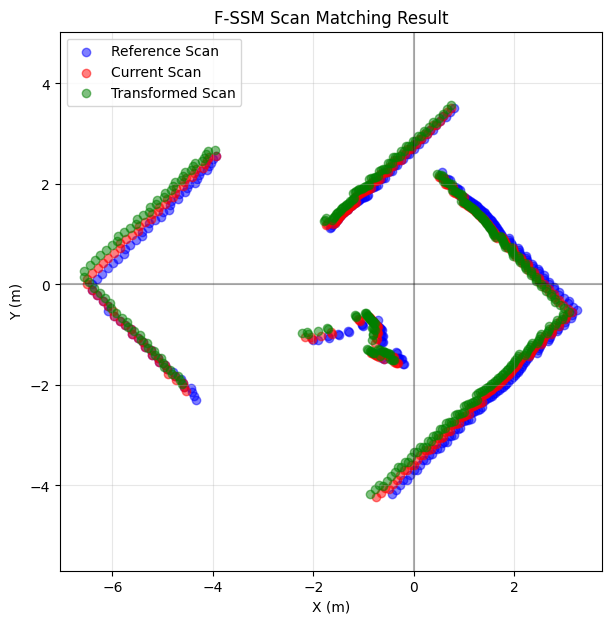


Running F-SSM localization demonstration...


In [ ]:
"""Demonstration of F-SSM with the NEU racing environment.

This script demonstrates how to use the F-SSM implementation with
the NEU racing environment that uses a Lidar sensor and Unicycle motion model.
"""

import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

import gym_neu_racing.motion_models as motion_models
import gym_neu_racing.sensor_models as sensor_models
from fssm_wrapper import FSsmWrapper

def visualize_scan_matching(reference_scan, current_scan, R, t):
    """Visualize scan matching results.

    Args:
        reference_scan (np.ndarray): Reference scan points
        current_scan (np.ndarray): Current scan points
        R (np.ndarray): Rotation matrix
        t (np.ndarray): Translation vector
    """
    plt.figure(figsize=(7, 7))

    # Plot reference scan
    plt.scatter(reference_scan[:, 0], reference_scan[:, 1], c='blue', label='Reference Scan', alpha=0.5)

    # Plot current scan before transformation
    plt.scatter(current_scan[:, 0], current_scan[:, 1], c='red', label='Current Scan', alpha=0.5)

    # Transform current scan and plot
    transformed_scan = (R @ current_scan.T).T + t
    plt.scatter(transformed_scan[:, 0], transformed_scan[:, 1], c='green', label='Transformed Scan', alpha=0.5)

    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.axis('equal')
    plt.title('F-SSM Scan Matching Result')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.show()

def simulate_lidar_scan(env_map, pose, num_beams=360, max_range=10.0):
    """Simulate a Lidar scan at the given pose.

    Args:
        env_map: Map object of the environment
        pose (np.ndarray): Robot pose [x, y, theta]
        num_beams (int): Number of Lidar beams
        max_range (float): Maximum sensing range

    Returns:
        dict: Simulated Lidar scan data
    """
    angles = np.linspace(0, 2*np.pi, num_beams, endpoint=False)
    ranges = np.full(num_beams, max_range)

    # Cast rays
    for i, angle in enumerate(angles):
        # Calculate absolute angle
        abs_angle = pose[2] + angle

        # Calculate ray direction
        dir_x = np.cos(abs_angle)
        dir_y = np.sin(abs_angle)

        # Ray origin
        ray_origin = pose[:2]

        # Perform ray casting
        for dist in np.arange(0.1, max_range, 0.1):
            # Calculate point along ray
            point_x = ray_origin[0] + dist * dir_x
            point_y = ray_origin[1] + dist * dir_y
            point = np.array([point_x, point_y])

            # Check if point is in map and occupied
            grid_coords, in_map = env_map.world_coordinates_to_map_indices(point)

            if not in_map:
                # Ray has left the map
                ranges[i] = dist
                break

            if env_map.static_map[grid_coords[0], grid_coords[1]]:
                # Ray has hit an obstacle
                ranges[i] = dist
                break

    return {'ranges': ranges, 'angles': angles}

def extract_scan_points(lidar_data):
    """Extract 2D points from Lidar data.

    Args:
        lidar_data (dict): Lidar data with 'ranges' and 'angles'

    Returns:
        np.ndarray: Array of 2D points, shape (n, 2)
    """
    ranges = lidar_data['ranges']
    angles = lidar_data['angles']

    # Convert to Cartesian coordinates
    x = ranges * np.cos(angles)
    y = ranges * np.sin(angles)

    return np.column_stack((x, y))

def demo_scan_matching_with_environment():
    """Demonstrate F-SSM scan matching with the NEU racing environment."""
    # Create environment
    env = gym.make('gym_neu_racing/NEUMapping-v0')

    # Reset environment
    observation, _ = env.reset()

    # Get map from environment
    env_map = env.unwrapped.map

    # Create FSSM wrapper
    fssm_wrapper = FSsmWrapper(bin_width=0.1, sigma_d=0.8)

    # Simulate a reference scan at initial pose
    initial_state = np.array([2.0, 0.0, np.pi/4])  # x, y, theta
    env.unwrapped.state = initial_state
    initial_pose = env.unwrapped.state.copy()
    reference_scan_data = simulate_lidar_scan(env_map, initial_pose)
    reference_scan_points = extract_scan_points(reference_scan_data)

    # Simulate movement with unicycle model
    motion_model = motion_models.Unicycle()
    action = np.array([1.0, 0.2])  # Forward velocity and angular velocity
    dt = 0.1
    new_pose = motion_model.step(initial_pose, action, dt)

    # Simulate a new scan at the new pose
    current_scan_data = simulate_lidar_scan(env_map, new_pose)
    current_scan_points = extract_scan_points(current_scan_data)

    # Perform scan matching
    R, t, success = fssm_wrapper.match_scans(current_scan_points, reference_scan_points)

    if success:
        print("Scan matching successful!")
        print(f"Rotation matrix:\n{R}")
        print(f"Translation vector: {t}")

        # Calculate estimated pose change
        delta_theta = np.arctan2(R[1, 0], R[0, 0])
        estimated_change = np.array([t[0], t[1], delta_theta])

        # Calculate actual pose change
        actual_change = new_pose - initial_pose

        print("\nPose Change Comparison:")
        print(f"Estimated: {estimated_change}")
        print(f"Actual: {actual_change[:3]}")
        print(f"Error: {np.linalg.norm(estimated_change - actual_change[:3])}")

        # Visualize scan matching
        visualize_scan_matching(reference_scan_points, current_scan_points, R, t)
    else:
        print("Scan matching failed")

    # Close environment
    env.close()

def demo_localization_with_fssm():
    """Demonstrate localization using F-SSM in the NEU racing environment."""
    # Create environment
    env = gym.make('gym_neu_racing/NEUMapping-v0')

    # Reset environment
    observation, _ = env.reset()

    # Get map from environment
    env_map = env.unwrapped.map

    # Create motion and sensor models
    motion_model = motion_models.Unicycle()
    #lidar_sensor = sensors.Lidar2D(env_map)
    env.unwrapped.sensor_models = {
    "state": sensor_models.StateFeedback(),
    "lidar": sensor_models.Lidar2D(
        env.unwrapped.map,
        num_beams=360,
        angle_limits=np.array([-np.pi, np.pi]),
    ),
    }

    lidar_sensor = env.unwrapped.sensor_models["lidar"]

    # Create FSSM wrapper
    fssm_wrapper = FSsmWrapper(bin_width=0.1, sigma_d=0.8)

    # Initial pose and localization state
    initial_state = np.array([2.0, 0.0, np.pi/4])  # x, y, theta
    env.unwrapped.state = initial_state
    true_pose = env.unwrapped.state.copy()
    estimated_pose = true_pose.copy()

    # Initial scan as reference
    reference_scan_data = simulate_lidar_scan(env_map, true_pose)

    # Create figure for visualization
    plt.figure(figsize=(7, 7))

    # Simulation steps
    num_steps = 20

    # Arrays to store data
    true_poses = [true_pose.copy()]
    estimated_poses = [estimated_pose.copy()]

    # Simulation loop
    for step in range(num_steps):
        # Apply a random action
        action = np.array([0.5, 0.1 * np.sin(step * 0.5)])  # Simple sinusoidal steering
        dt = 0.1

        # Update true pose
        true_pose = motion_model.step(true_pose, action, dt)

        # Simulate Lidar scan at true pose
        current_scan_data = simulate_lidar_scan(env_map, true_pose)

        # Estimate pose change using F-SSM
        delta_pose, confidence = fssm_wrapper.estimate_pose_change(
            current_scan_data, reference_scan_data, estimated_pose)

        # Update estimated pose
        estimated_pose[0] += delta_pose[0]
        estimated_pose[1] += delta_pose[1]
        estimated_pose[2] += delta_pose[2]

        # Normalize angle
        estimated_pose[2] = (estimated_pose[2] + np.pi) % (2 * np.pi) - np.pi

        # Store poses for plotting
        true_poses.append(true_pose.copy())
        estimated_poses.append(estimated_pose.copy())

        # Use current scan as reference for next iteration
        reference_scan_data = current_scan_data

        print(f"Step {step+1}/{num_steps}")
        print(f"True Pose: {true_pose}")
        print(f"Estimated Pose: {estimated_pose}")
        print(f"Estimation Error: {np.linalg.norm(true_pose - estimated_pose)}")
        print(f"Confidence: {confidence}")
        print("---")

    # Convert to numpy arrays for plotting
    true_poses = np.array(true_poses)
    estimated_poses = np.array(estimated_poses)

    # Plot result
    plt.subplot(1, 1, 1)
    plt.plot(true_poses[:, 0], true_poses[:, 1], 'b-', label='True Path')
    plt.plot(estimated_poses[:, 0], estimated_poses[:, 1], 'r--', label='Estimated Path')
    plt.scatter(true_poses[0, 0], true_poses[0, 1], c='g', s=100, marker='o', label='Start')
    plt.scatter(true_poses[-1, 0], true_poses[-1, 1], c='r', s=100, marker='x', label='End')

    # Draw environment map
    env_map.draw_map(show=False, ax=plt.gca())

    plt.legend()
    plt.title('Localization using F-SSM')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.axis('equal')
    plt.grid(alpha=0.3)
    plt.show()

    # Close environment
    env.close()

if __name__ == "__main__":
    print("Running F-SSM scan matching demonstration...")
    demo_scan_matching_with_environment()

    try:
        #import gym_neu_racing.SensorModel as sensors
        from gym_neu_racing.sensor_models.sensor_model import SensorModel as sensors
        print("\nRunning F-SSM localization demonstration...")
        demo_localization_with_fssm()
    except ImportError:
        print("\nSkipping localization demo due to missing sensors module.")
        print("Please ensure you have the appropriate sensor model set up.")